In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1").ffill()
words = list(data["Word"].unique())
tags = list(data["Tag"].unique())

if "ENDPAD" not in words:
    words.append("ENDPAD")

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

KeyError: 'Word'

In [ ]:
data.head(50)

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

In [ ]:
print("Unique tags are:", tags)

In [ ]:
# Group words by sentences
class SentenceGetter:
    def __init__(self, data):
        self.grouped = data.groupby("Sentence #", group_keys=False).apply(
            lambda s: [(w, t) for w, t in zip(s["Word"], s["Tag"])]
        )
        self.sentences = list(self.grouped)

getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[35]

In [ ]:
# Encode sentences
X = [[word2idx[w] for w, t in s] for s in sentences]
y = [[tag2idx[t] for w, t in s] for s in sentences]

In [ ]:
word2idx

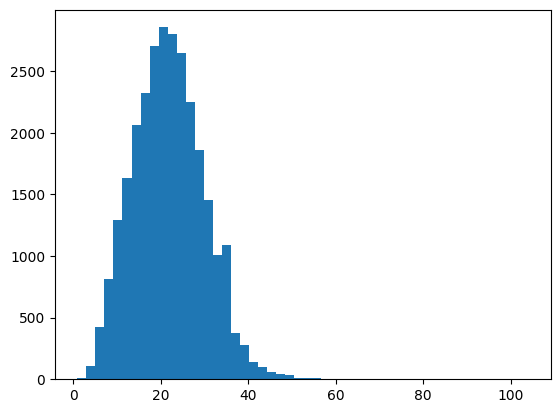

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
# Pad sequences
max_len = 50
X_pad = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True, padding_value=word2idx["ENDPAD"])
y_pad = pad_sequence([torch.tensor(seq) for seq in y], batch_first=True, padding_value=tag2idx["O"])
X_pad = X_pad[:, :max_len]
y_pad = y_pad[:, :max_len]

In [ ]:
X_pad[0]


tensor([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
           11,    12,    13,    14,    15,    10,    16,     2,    17,    18,
           19,    20,    21,    22, 27509, 27509, 27509, 27509, 27509, 27509,
        27509, 27509, 27509, 27509, 27509, 27509, 27509, 27509, 27509, 27509,
        27509, 27509, 27509, 27509, 27509, 27509, 27509, 27509, 27509, 27509])

In [ ]:
y_pad[0]

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=1)

In [ ]:
# Dataset class
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "input_ids": self.X[idx],
            "labels": self.y[idx]
        }

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=32)

In [ ]:
class BiLSTMTagger(nn.Module):
  def __init__(self, vocab_size, tagset_size, embedding_dim = 50, hidden_dim = 100):
    super(BiLSTMTagger, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout = nn.Dropout(0,1)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
    self.fc = nn.Linear(hidden_dim * 2, tagset_size)

  def forward(self, x):
    x = self.embedding(x)
    x = self.dropout(x)
    x, _ = self.lstm(x)
    return self.fc(x)

In [ ]:
model = BiLSTMTagger(len(word2idx)+1, len(tag2idx)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
      model.train()
      total_loss = 0
      for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = loss_fn(outputs.view(-1, len(tag2idx)), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
      train_losses.append(total_loss)

      model.eval()
      val_loss = 0
      with torch.no_grad():
        for batch in test_loader:
          input_ids = batch["input_ids"].to(device)
          labels = batch['labels'].to(device)
          outputs = model(input_ids)
          loss = loss_fn(outputs.view(-1, len(tag2idx)), labels.view(-1))
          val_loss += loss.item()
      val_losses.append(val_loss)
      print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Val Loss = {val_loss:.4f}")

    return train_losses, val_losses

In [ ]:
def evaluate_model(model, test_loader, X_test, y_test):
    model.eval()
    true_tags, pred_tags = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=-1)
            for i in range(len(labels)):
                for j in range(len(labels[i])):
                    if labels[i][j] != tag2idx["O"]:
                        true_tags.append(idx2tag[labels[i][j].item()])
                        pred_tags.append(idx2tag[preds[i][j].item()])


# Run training and evaluation
train_losses, val_losses = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3)
evaluate_model(model, test_loader, X_test, y_test)
